# Robust Genomic Feature Selection Pipeline using an Ensemble of xAI Methods

## Imports

In [ ]:
!git clone https://github.com/vladislareon/Sparse_vector
!git clone https://github.com/vladislareon/z_dna

Cloning into 'Sparse_vector'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), done.
Cloning into 'z_dna'...
remote: Enumerating objects: 2052, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 2052 (delta 8), reused 0 (delta 0), pack-reused 2021 (from 1)
Receiving objects: 100% (2052/2052), 1.75 GiB | 27.07 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (2024/2024), done.


In [ ]:
!git clone https://github.com/vladislareon/Interpretation

Cloning into 'Interpretation'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 14), reused 2 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 67.14 KiB | 4.48 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [ ]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# imports
import os
import numpy as np
import pandas as pd

from joblib import load
from tqdm.notebook import tqdm
from torch.utils import data

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from IPython.display import clear_output

import torch
from torch.utils import data

from Sparse_vector.sparse_vector import SparseVector
from data_preparation import chrom_reader, get_train_test_dataset
from train_test import set_random_seed, train
from cnn_model import DeepCNN_12_layers
from interpretation import cnn_interpretation_pipeline, get_ranked_features


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Data Preparation

In [ ]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features]

In [ ]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}

# choose ZDNA Data to load
# ZDNA_shin = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
# ZDNA_cousine = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 1min 21s, sys: 5.77 s, total: 1min 27s
Wall time: 1min 55s


In [ ]:
np.random.seed(10)

# recommended width of the interval = 100
width = 100

train_dataset, test_dataset = get_train_test_dataset(width, chroms, feature_names, DNA, DNA_features, ZDNA)


100%|█████████████████████████████████████████████████████████████████████| 2489564/2489564 [00:29<00:00, 83320.77it/s]

100%|█████████████████████████████████████████████████████████████████████| 2421935/2421935 [00:28<00:00, 84597.23it/s]

100%|█████████████████████████████████████████████████████████████████████| 1982955/1982955 [00:23<00:00, 85782.93it/s]

100%|█████████████████████████████████████████████████████████████████████| 1902145/1902145 [00:22<00:00, 85186.87it/s]

100%|█████████████████████████████████████████████████████████████████████| 1815382/1815382 [00:21<00:00, 84955.91it/s]

100%|█████████████████████████████████████████████████████████████████████| 1708059/1708059 [00:19<00:00, 89557.33it/s]

100%|█████████████████████████████████████████████████████████████████████| 1593459/1593459 [00:18<00:00, 84645.67it/s]

100%|█████████████████████████████████████████████████████████████████████| 1451386/1451386 [00:16<00:00, 89451.53it/s]

100%|██████████████████████████

In [ ]:
params = {'batch_size':1,
          'num_workers':20,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

## Init Model

In [ ]:
set_random_seed(42)
torch.cuda.empty_cache()

with torch.cuda.device(device):
    model = DeepCNN_12_layers(width, features_count=len(feature_names))
    model = model.to(device)

## Train Model

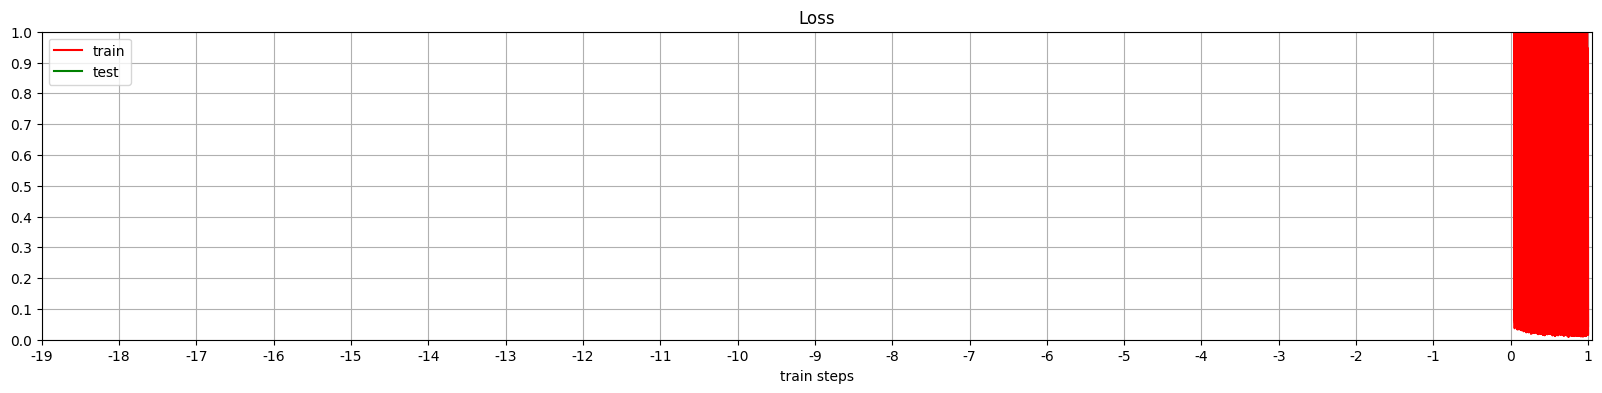

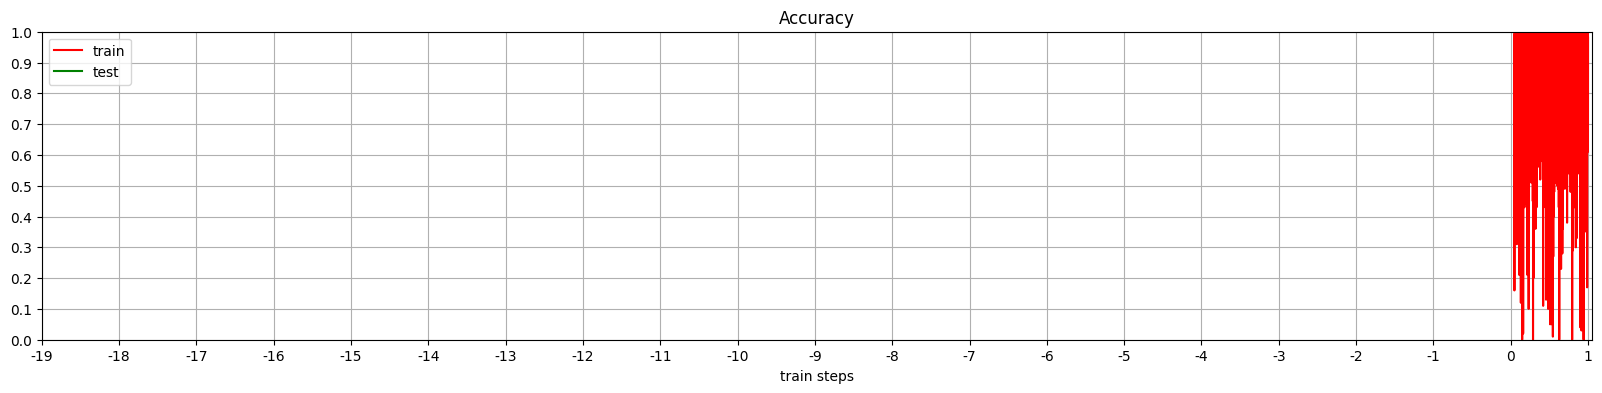

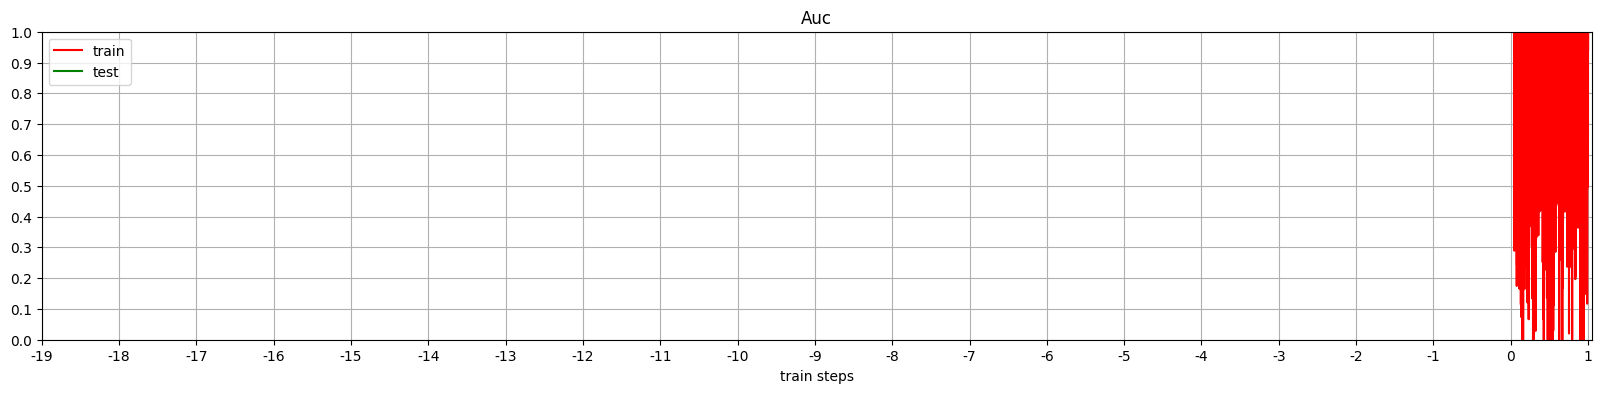

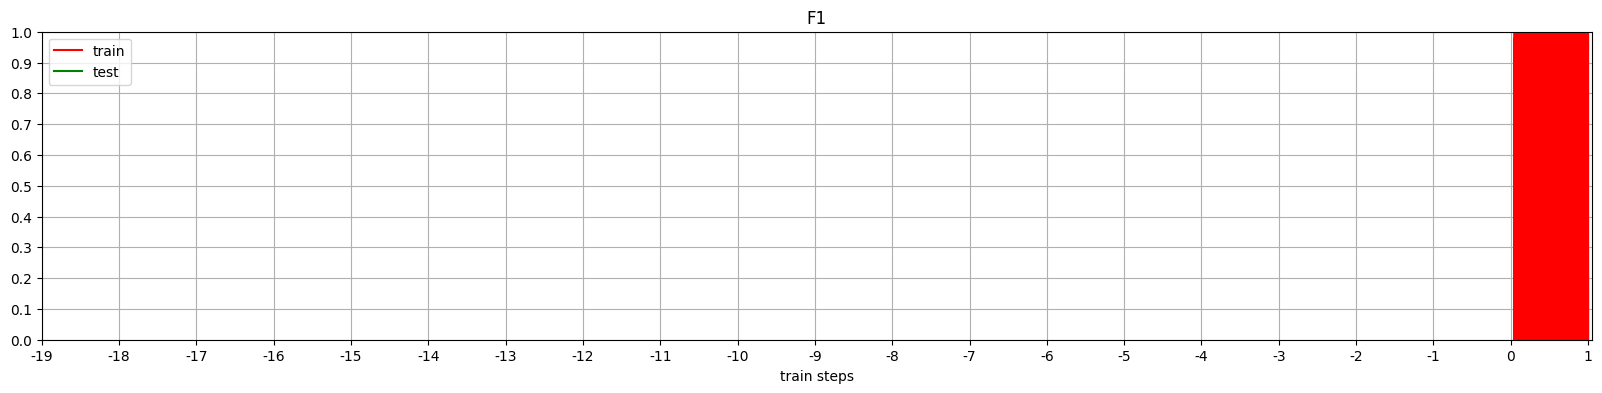

Time:  29025485.945448842
Epoch 1: ROC-AUC = 97.77%
Epoch 1: Precision = 0.835
Epoch 1: Recall = 0.858
Epoch 1: F1-score = 0.833
Final ROC-AUC = 97.77%
Final Precision = 0.835
Final Recall = 0.858
Final F1-score = 0.833


In [ ]:
n_epochs = 1
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(model, opt, n_epochs, loader_train, loader_test)

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 0
Max F1-score: 83.2758%
ROC-AUC: 97.7666%
Precision: 0.8347
Recall: 0.8575
Mean time for 1 epoch 188.84 minutes


## Interpretation Pipeline for CNN Model: instruction

In [ ]:
'''
algorithm can be:

- IntegratedGradients = default
- GuidedBackprop
- Deconvolution
- InputXGradient

model is trained and interpretated model; in eval()

loader_test, loader_train is interpreted data

width is width of the interval

save_filename is name of saved file

need_return whether output of interpretation is needed; 0 or 1

'''

In [ ]:
'''
# example

cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_GraphZSAGEConv_v5_lin_GuidedBackprop','GuidedBackprop', need_return=0)
# or
mean_GB = cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_GraphZSAGEConv_v5_lin_GuidedBackprop', 'GuidedBackprop', need_return=1)
'''

## Interpretation

In [ ]:
model.eval()

DeepCNN_12_layers(
  (seq): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): GroupNorm(2, 4, eps=1e-05, affine=True)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): GroupNorm(4, 8, eps=1e-05, affine=True)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): GroupNorm(8, 16, eps=1e-05, affine=True)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): GroupNorm(16, 32, eps=1e-05, affine=True)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): GroupNorm(16, 64, eps=1e-05, affine=True)
    (15): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (16): ReLU()
    (17): GroupNorm(32, 128, eps=1e-05, affine=True)
    (18): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU()
    (20): Grou

In [ ]:
mean_GB = cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_GuidedBackprop', 'GuidedBackprop', need_return=1)

  0%|          | 0/36160 [00:00<?, ?it/s]

/home/aamelia/python3.11-env/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/aamelia/python3.11-env/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([-0.0195,  0.0066,  0.0091,  ...,  0.0669,  0.0984,  0.0878],
       dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_GuidedBackprop.pt


In [ ]:
mean_IG = cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_IntegratedGradients', 'IntegratedGradients', need_return=1)

  0%|          | 0/36160 [00:00<?, ?it/s]

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([ 2.8297e-02,  9.3231e-01, -2.0669e-01,  ...,  0.0000e+00,
        -2.1826e-03,  6.6398e-06], dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_IntegratedGradients.pt


In [ ]:
mean_DEC = cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_Deconvolution', 'Deconvolution', need_return=1)

  0%|          | 0/36160 [00:00<?, ?it/s]

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([-3.6229,  4.1320,  4.5062,  ..., -0.4396, -3.3738,  0.4619],
       dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_Deconvolution.pt


In [ ]:
mean_IXG = cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_InputXGradient', 'InputXGradient', need_return=1)

  0%|          | 0/36160 [00:00<?, ?it/s]

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([-1.0410e-01,  3.7796e-01,  5.2939e-03,  ...,  0.0000e+00,
         7.7874e-05,  4.7875e-07], dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_InputXGradient.pt


## Ranking

In [ ]:
# in our features data first 4 indices correspond to ACTG
# as we are interested in omics data, we will remove ACTG before feature ranking

mean_IG = mean_IG[4:]
mean_IXG = mean_IXG[4:]
mean_DEC = mean_DEC[4:]
mean_GB = mean_GB[4:]

In [ ]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG, 'DEC' : mean_DEC, 'GB' : mean_GB}
features_weights = pd.DataFrame(features_weights)

In [ ]:
features_weights.head()

,IG,IXG,DEC,GB
0,-8.214454e-03,-0.010688,3.919184,-0.000150
1,-1.275051e-02,-0.006882,2.811056,0.000245
2,5.338189e-07,0.000001,1.209194,-0.002471
3,-8.770335e-04,-0.000180,0.042775,-0.003220
4,-8.980475e-04,-0.000385,-0.445984,-0.002381


In [ ]:
features_range = get_ranked_features(features_weights)

In [ ]:
features_range.head()

,mean_deviation
156,8656.463769
224,6624.349218
154,5420.645935
1906,4785.461202
699,4717.273185


## Load Extracted Features

In [ ]:
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
feature_names = [i for i in features]

# the number of extracted features
top_count = 100
features_top = features_range.iloc[:top_count].index.tolist()

top = []
for index in features_top:
    top.append(features[index])


features = top
feature_names = [i for i in features]

In [ ]:
DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
np.random.seed(10)

width = 100

train_dataset, test_dataset = get_train_test_dataset(width, chroms, feature_names, DNA, DNA_features, ZDNA)

100%|█████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 64305.91it/s]


In [ ]:
np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

## Train Model On New Features

In [ ]:
set_random_seed(42)
torch.cuda.empty_cache()

with torch.cuda.device(device):
    model = DeepCNN_12_layers(width, top_count)
    model = model.to(device)

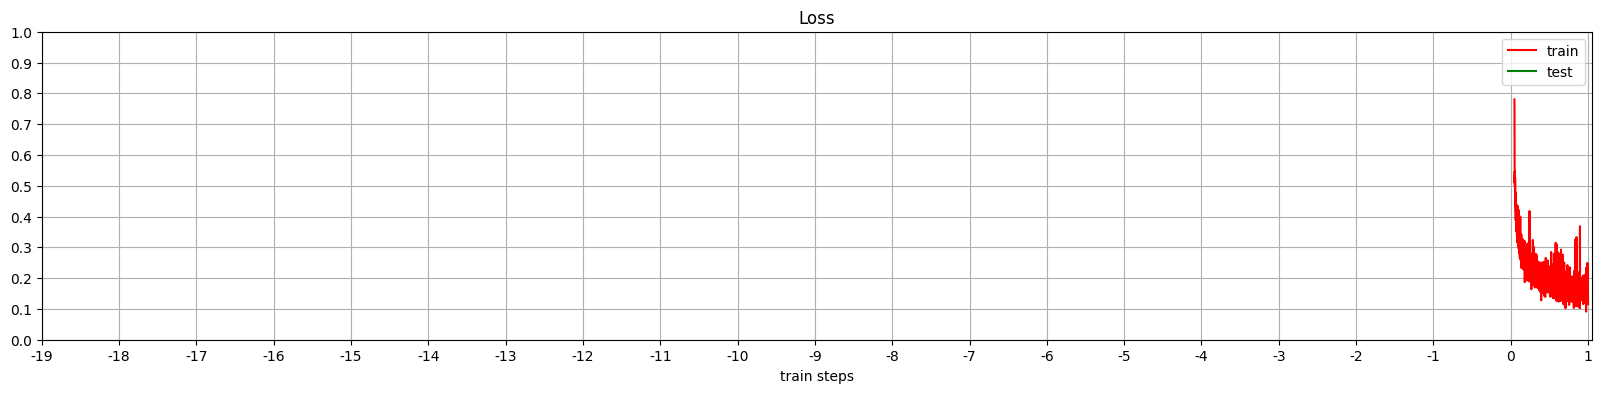

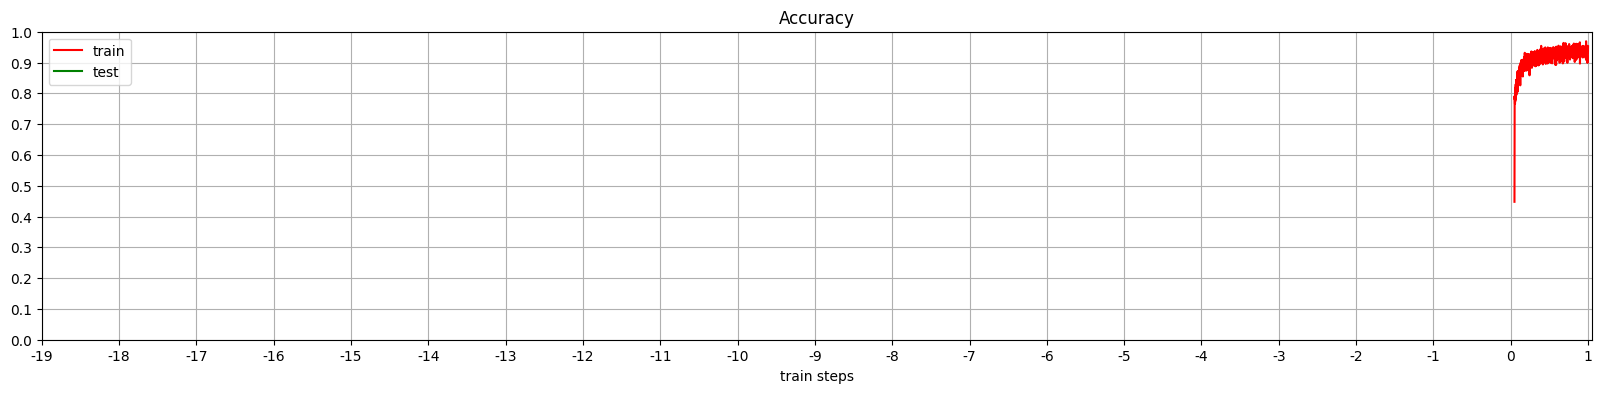

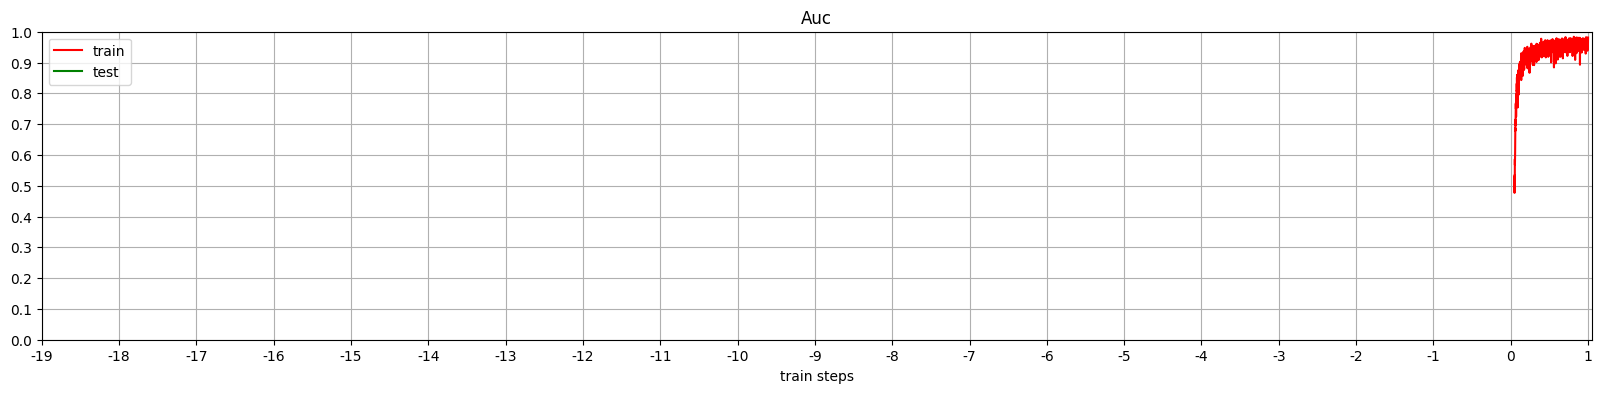

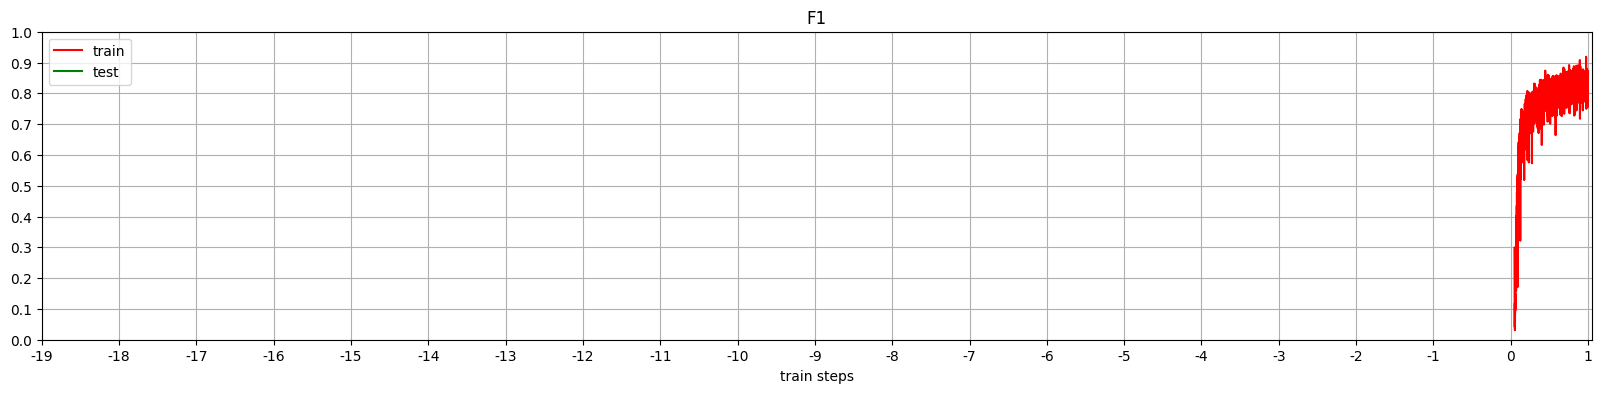

Time:  29026148.58878406
Epoch 1: ROC-AUC = 97.30%
Epoch 1: Precision = 0.893
Epoch 1: Recall = 0.822
Epoch 1: F1-score = 0.855
Final ROC-AUC = 97.3%
Final Precision = 0.893
Final Recall = 0.822
Final F1-score = 0.855


In [ ]:
n_epochs = 1
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(model, opt, n_epochs, loader_train, loader_test)

In [ ]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 0
Max F1-score: 85.5458%
ROC-AUC: 97.2985%
Precision: 0.8935
Recall: 0.8220
Mean time for 1 epoch 3.46 minutes
